In [40]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from pyAgrum.lib.pretty_print import pretty_cpt

from IPython.display import display, Math, Latex

%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

# Hector le robot jongleur
>from Roland Donat

Hector, le robot jongleur, lâche souvent les balles avec lesquelles il jongle quand sa batterie est faible. D'après les expériences précédentes, il a été déterminé que la probabilité qu'il lâche une balle quand sa batterie est faible est de $0.9$. D'autre part, quand sa batterie n'est pas faible, la probabilité qu'il lâche une balle est seulement de $0.01$. Quand la batterie a été rechargée il y a peu de temps, il y a seulement $5\%$ de chances que la batterie soit faible contre $50\%$ si la batterie n'a pas été rechargée récemment. 

Un premier système de vision $O1$ (peu fiable) observe le robot et nous prévient lorsqu'il croit que Hector a lâché une balle. Un autre système $O2$ (indépendant du premier) agit de la même façon. Le but de cet exercice est de modéliser les résultats des observateurs en fonction de ce que fait Hector et de son état. 

## Structure du réseau bayésien

Construire un BN pour ce problème en considérant :

+ Quelles variables (booléenne) de modélisation ?

    * R : batterie rechargée

    * B : batterie faible

    * L : le robot a laché un ballon

    * O1 : l'observateur 1 voit un ballon laché par le robot

    * O2 : l'observateur 2 voit un ballon laché par le robot

+ Quelle structure ?
    * R->B->L
    * L-> O1
    * L-> O2
+ Quelle est la forme de la distribution de probabilité jointe pour ce BN
    * P(R,B,L,O1,O2) = P(R)P(B/R)P(L,B)P(O1/L)P(O2/L)
+ $O1$ et $O2$ sont ils indépendantes ? A quelle condition deviennent-elles indépéndantes ?
    * le seul chemin reliant O1 et O2 (O1<-L->O2) n'est pas un chemin bloqué pour l'indépendance de O1 et O2, donc O1 et O2 ne sont pas indépendants.
    * si on connait L, alors le chemin est bloqué entre O1 et O2, et on a alors O1 indépendant de O2 (sachant L)

## Paramètres du réseau bayésien

Proposer les CPTs pour le BN. Quelle données vous manque-t-il pour avoir l'ensemble du modèle bien renseigné ?
* il va manquer les tables de propriétés conditionnelles de O1/L et O2/L

In [49]:
bn = gum.BayesNet()
# définition des variables
o1 = gum.LabelizedVariable("O1","",0).addLabel("O").addLabel("N") # o1 observe un lacher du ballon
o2 = gum.LabelizedVariable("O2","",0).addLabel("O").addLabel("N") 
b = gum.LabelizedVariable("B","",0).addLabel("O").addLabel("N") # batterie faible
l = gum.LabelizedVariable("L","",0).addLabel("O").addLabel("N") # le robot a laché le ballon
r = gum.LabelizedVariable("R","",0).addLabel("O").addLabel("N")  # la batterie a été rechargé récemment
oo1 = bn.add(o1)
oo2 = bn.add(o2)
bb = bn.add(b)
ll = bn.add(l)
rr = bn.add(r)
# définition des arcs
bn.addArc(ll,oo1)
bn.addArc(ll,oo2)
bn.addArc(bb,ll)
bn.addArc(rr,bb)
gnb.showBN(bn)
# defintion des probabilités a priori
bn.cpt(rr).fillWith([0.5,0.5])
bn.cpt(bb)[{"R":"O"}] = [0.05,0.95]
bn.cpt(bb)[{"R":"N"}] = [0.5,0.5]
bn.cpt(ll)[{"B": "O"}] = [0.9,0.1]
bn.cpt(ll)[{"B": "N"}] = [0.01,0.99]

## inférence dans le réseau bayésien

On suppose maintenant que la fiabilité des observateurs $O1$ et $O2$ est de respectivement $70\%$ et $90\%$.

In [50]:
bn.cpt(oo1)[{"L":"O"}] = [0.7,0.3]
bn.cpt(oo1)[{"L":"N"}] = [0.3,0.7]

bn.cpt(oo2)[{"L":"O"}] = [0.9,0.1]
bn.cpt(oo2)[{"L":"N"}] = [0.1,0.9]


+ Calculer la probabilité a priori de chaque nœud

probabilités a priori des variables :


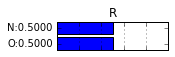

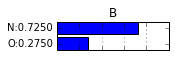

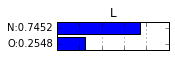

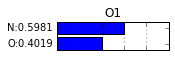

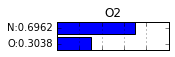

In [56]:
ie = gum.LazyPropagation(bn)
print("probabilités a priori des variables :")
ie.makeInference()

gnb.showProba(ie.posterior(rr))
gnb.showProba(ie.posterior(bb))
gnb.showProba(ie.posterior(ll))
gnb.showProba(ie.posterior(oo1))
gnb.showProba(ie.posterior(oo2))


+ $O1$ observe que Hector a lâché la balle. Quelle est la probabilité que la batterie soit faible ? Comparer cette valeur avec sa probabilité à priori.


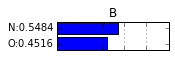

In [57]:
ie = gum.LazyPropagation(bn)
ie.setEvidence({'O1':"O"})
ie.makeInference()
gnb.showProba(ie.posterior(bb))

=> la probabilité que la batterie soit faible est maintenant plus forte car via O1, on a l'information plutôt fiable qu'un ballon a été laché et que donc la robot n'est pas bien chargé.

+ On ajoute que $O2$ n'a rien vu. Quelle est la nouvelle probabilité que la batterie soit faible ?

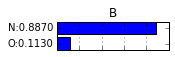

In [58]:
#ie = gum.LazyPropagation(bn)
ie.setEvidence({'O1':"O","O2":"N"})
ie.makeInference()
gnb.showProba(ie.posterior(bb))

=> Cette fois, c'est l'inverse : la probabilité est maintenant bien plus faible car via O2, on a l'information très fiable qu'un ballon n'a pas été laché et que donc le robot est bien chargé, cela en dépit de l'observation contraire de O1, observation qui patit de sa fiabilité plus faible.
D'ailleurs, si O1 n'avait rien vu non plus, la probabilité serait encore plus forte que la batterie est bien chargé:

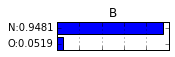

In [64]:
#ie = gum.LazyPropagation(bn)
ie.setEvidence({"O1":"N","O2":"N"})
ie.makeInference()
gnb.showProba(ie.posterior(bb))